# Melanoma Detection:
Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import random
from glob import glob
import Augmentor

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Importing Skin Cancer Data

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
Train_data_path = "Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
Test_data_path = "Skin cancer ISIC The International Skin Imaging Collaboration/Test/"

data_dir_train = pathlib.Path(Train_data_path)
data_dir_test = pathlib.Path(Test_data_path)

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

#### Load data using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [6]:
# Dataset for training
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Train_data_path,
    labels='inferred',
    label_mode='int', #'categorical',
    #class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format= 'channels_last',
    verbose=True
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
# Dataset for validation
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Train_data_path,
    labels='inferred',
    label_mode='int', #'categorical',
    #class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format= 'channels_last',
    verbose=True
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


#### Class names from dataaset

In [8]:

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

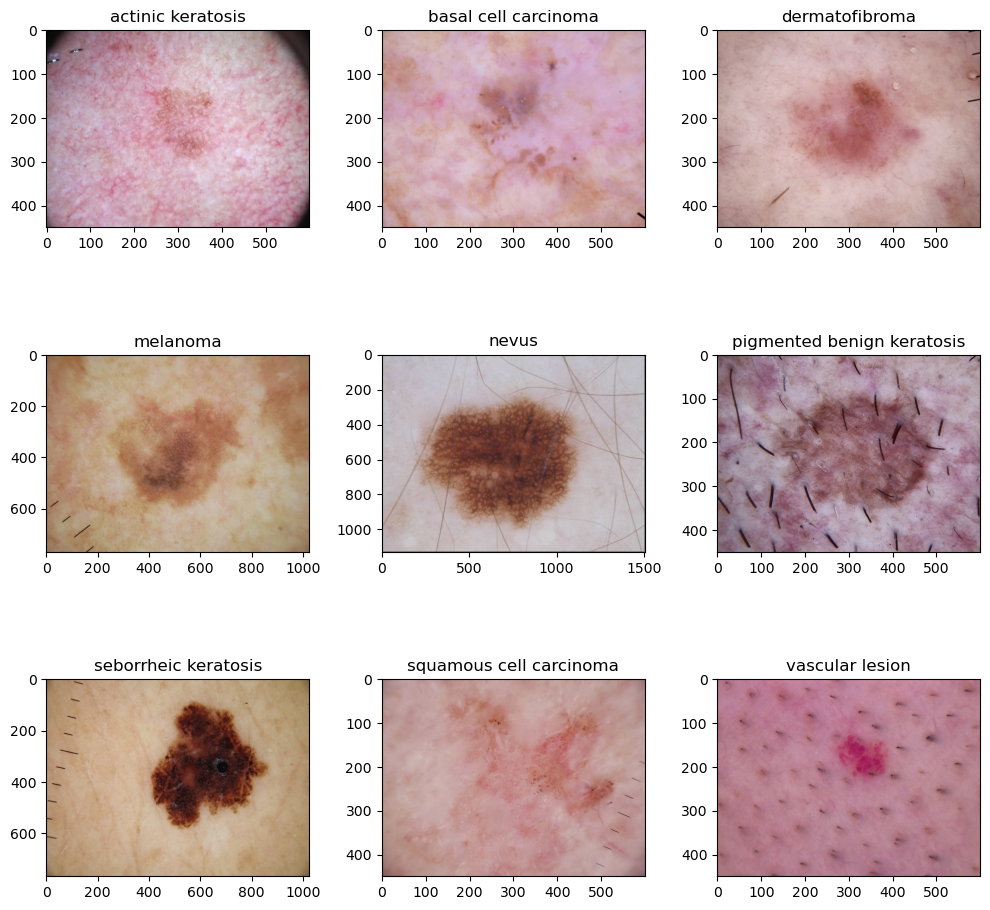

In [9]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    
    filenames = os.listdir(os.path.join(Train_data_path, class_names[i]))
    image = Image.open(os.path.join(Train_data_path, class_names[i],random.choice(filenames) ))
    
    ax.imshow(np.asarray(image).astype("uint8"))
    ax.set_title(class_names[i])

plt.tight_layout()
plt.show()

In [10]:
# Validate dimentions of input and labels for one batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model:

#### Normalization layer:

The input image is a color image and each pixel value ranges from 0 to 255. To rescale image pixel values we use normalization layer as follows.

In [12]:

normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.08093094 0.9892081


### Build model v1:

In [13]:
num_classes = 9

model_v1 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(8, 3, padding="same",activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])

#### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
### Todo, choose an appropirate optimiser and loss function
model_v1.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model_v1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 8)    │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    15,860,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,875,993 (60.56 MB)

 Trainable params: 15,875,993 (60.56 MB)

 Non-trainable params: 0 (0.00 B)

#### Train the model

In [135]:
epochs = 20
history = model_v1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 15s 249ms/step - accuracy: 0.1726 - loss: 3.2155 - val_accuracy: 0.2752 - val_loss: 1.9225
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.2959 - loss: 1.9081 - val_accuracy: 0.3378 - val_loss: 1.7959
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 244ms/step - accuracy: 0.4036 - loss: 1.6881 - val_accuracy: 0.4586 - val_loss: 1.6431
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.4369 - loss: 1.5956 - val_accuracy: 0.5213 - val_loss: 1.4714
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.5251 - loss: 1.4078 - val_accuracy: 0.5078 - val_loss: 1.4481
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.5491 - loss: 1.2635 - val_accuracy: 0.5168 - val_loss: 1.4093
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.6275 - loss: 1.0812 - val_accuracy: 0.5280 - val_loss: 1.4209
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 243ms/step - accuracy: 0.6413 - loss: 1.0205 - val_accu

#### Visualizing training results

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(5, 10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

#### Findings from model_v1:

 - From the accuracy plot we can observe that model accuracy is high for training and low for validation. So the current model is overfitting for given data.
 - To solve this problem we can do regularization methods on model architecture.

#### Data augmentation:

In [17]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.25), # Rotating image with factor of 25% of 2pi [-25% * 2pi, 25% * 2pi]
  layers.RandomBrightness(0.3, value_range=(0, 255))
])

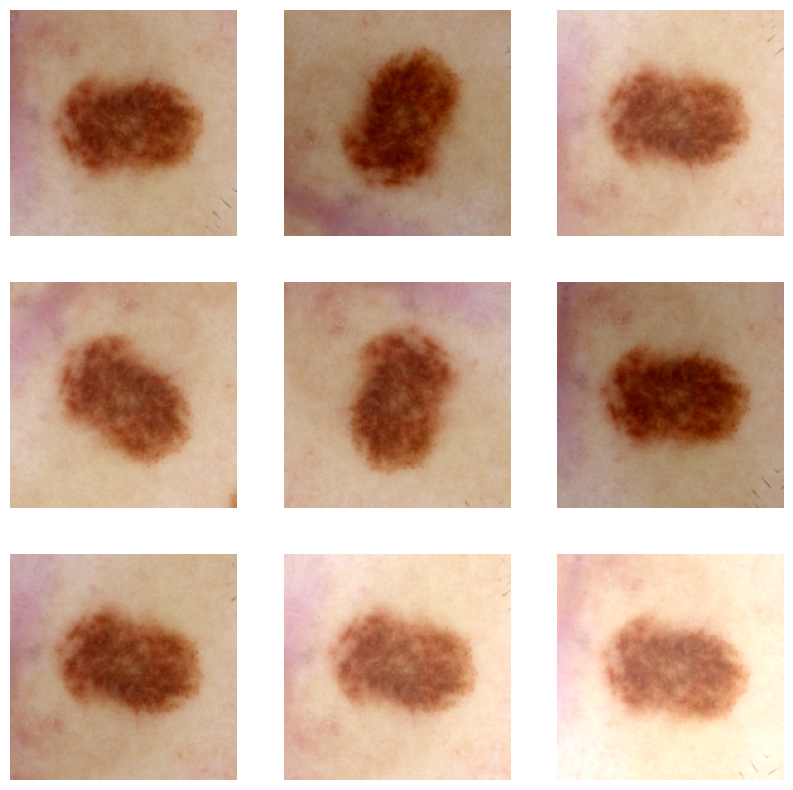

In [18]:
# Visualizing data augmentation Strategy
image_batch, label_batch = next(iter(train_ds))
first_image = image_batch[0]
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(first_image)
  ax = plt.subplot(3, 3, i + 1)
  outimage = augmented_image.numpy()
  plt.imshow(outimage.astype('uint8') )
  plt.axis("off")
    


### Build Model_v2:
Build CNN classification model with regularization layers(dropout).


In [19]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model_v2 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),
  tf.keras.layers.Rescaling(1./255),
  #layers.RandomFlip("horizontal_and_vertical"),  # Augmentation layer fplipping
  #layers.RandomRotation(0.25),  # Augmentation layer rotation
  tf.keras.layers.Conv2D(8, 3, padding="same",activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(16, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3,padding="same", activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])



#### Compiling the model

In [20]:
## Your code goes here
model_v2.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

#### Training the model

In [21]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model_v2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/20


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 9)

#### Visualizing the results

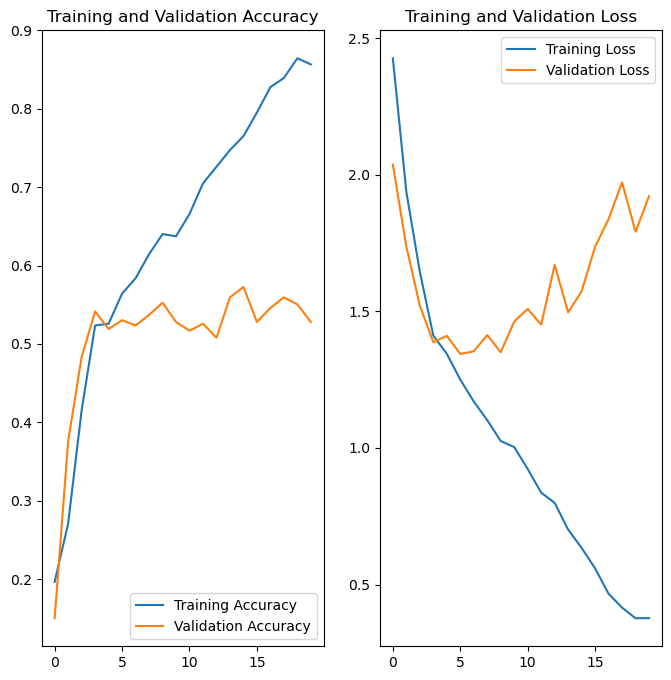

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

After adding dropout layer in network, we can observe that there is a slight change in the accuracy gap between training and validation. But still model is overfitting on training data.

### Data distribution analysis:

After adding regularization to the network still the overfitting problem is not solved. So we will analyze the data distribution for classes from training data to take necessary action.

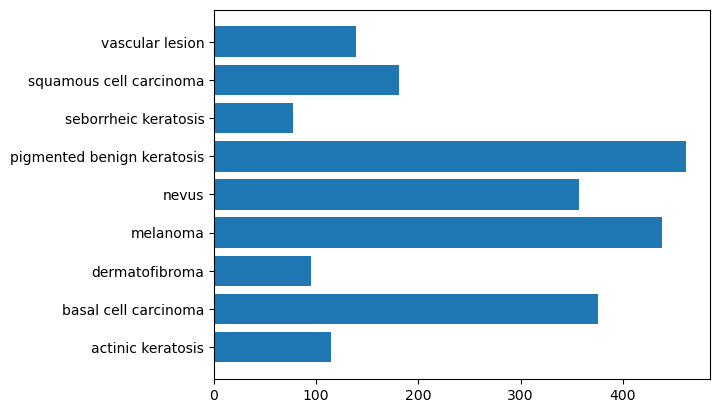

In [22]:
## Your code goes here.
num_images_classes = []
for class_name in class_names:
    num_images_class = len(os.listdir(os.path.join(Train_data_path,class_name)))
    num_images_classes.append(num_images_class)
plt.barh(range(len(num_images_classes)), num_images_classes, tick_label=class_names)
plt.show()

#### Findings fromn training Data distribution : 
From the plot shown above there is a significant imbalance in class distribution 
 - 'seborrheic keratosis' class has least number of training samples.
 - 'pigmented benign keratosis' class dominating other classes in terms of number of training samples.


### Augmentor for class balancing:
To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [24]:


samples_per_class = 608 # All classes will have 608 images after balancing using data augmentation(608 is divisible by 32)
for idx, class_name in enumerate(class_names):
    p = Augmentor.Pipeline(Train_data_path + class_name)
    # Now we add a rotate operation to the pipeline
    #p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)# Using at inbuilt model
    # Now we add a Horizontal flip operation to the pipeline
    #p.flip_left_right(probability=0.4) # Using at inbuilt model
    # Now we add a vertical flip operation to the pipeline
    #p.flip_top_bottom(probability=0.4) # Using at inbuilt model
    # Now we add a shear operation to the pipeline
    p.random_contrast(probability=0.5, min_factor=0.9, max_factor=1.4)
    p.random_brightness(probability = 0.5, min_factor=0.4, max_factor=0.9)
    p.shear(probability=0.5, max_shear_left=0.5,max_shear_right=0.5)
    p.sample(samples_per_class-num_images_classes[idx]) ## We are making 600 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2372C114AD0>: 100%|██████████| 494/494 [00:04<00:00, 120.73 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2372C0D8F10>: 100%|██████████| 232/232 [00:01<00:00, 123.76 Samples/s]                  


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x236A3CD2890>: 100%|██████████| 513/513 [00:04<00:00, 116.23 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2372D12D290>: 100%|██████████| 170/170 [00:09<00:00, 17.53 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2372C114F90>: 100%|██████████| 251/251 [00:10<00:00, 25.08 Samples/s]                    


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2372C0D3550>: 100%|██████████| 146/146 [00:01<00:00, 110.47 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x2372B24FC90>: 100%|██████████| 531/531 [00:13<00:00, 39.01 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x2372D1ADC90>: 100%|██████████| 427/427 [00:03<00:00, 110.58 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x236A54CC550>: 100%|██████████| 469/469 [00:04<00:00, 114.41 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [78]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4061


#### Data/class distribution after adding images from augmentation:

In [79]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [80]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]

In [81]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [82]:
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [83]:
lesion_list_original = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train,'*','./', '*.jpg'))]

In [84]:
original_data = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(original_data.items()),columns = ['Path','Label'])

In [85]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = pd.concat([original_df, df2])

In [86]:
new_df['Label'].value_counts()

Label
actinic keratosis             700
basal cell carcinoma          700
dermatofibroma                700
melanoma                      700
nevus                         700
pigmented benign keratosis    700
seborrheic keratosis          700
squamous cell carcinoma       700
vascular lesion               700
Name: count, dtype: int64

So, now we have added augmented images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Dataset preparation after balancing:

In [87]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [147]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Train_data_path,
  seed=123,
  validation_split = 0.2,
  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6300 files belonging to 9 classes.
Using 5040 files for training.


#### Create a validation dataset

In [148]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  Train_data_path,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6300 files belonging to 9 classes.
Using 1260 files for validation.


### Build model_v3:

After data balancing build new model with batchnormalization layers. And train with balance data.

In [170]:
## your code goes here
## You can use Dropout layer if there is an evidence of overfitting in your findings

num_classes = 9

model_v3 = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180,180,3)),

  tf.keras.layers.Rescaling(1./255),
    
  tf.keras.layers.RandomFlip(mode="horizontal_and_vertical"),# non trainable mute at inference
  tf.keras.layers.RandomRotation(0.25), # non trainable mute at inference
  
  tf.keras.layers.Conv2D(16, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
  
  tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),

  tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
  tf.keras.layers.MaxPooling2D(),
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(num_classes, activation='softmax')
])



#### Compile model:

In [171]:
## your code goes here

### Todo, choose an appropirate optimiser and loss function
model_v3.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model_v3.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_21 (Rescaling)        │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_12 (RandomFlip)     │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_11              │ (None, 180, 180, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_51 (Dense)                │ (None, 2048)           │    63,440,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,518,185 (246.12 MB)

 Trainable params: 64,518,185 (246.12 MB)

 Non-trainable params: 0 (0.00 B)

#### **Todo:**  Train your model

In [ ]:
epochs = 30
history = model_v3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)## your training code

Epoch 1/30
125/158 ━━━━━━━━━━━━━━━━━━━━ 31s 943ms/step - accuracy: 0.1567 - loss: 2.2483

#### Visualize the model results:

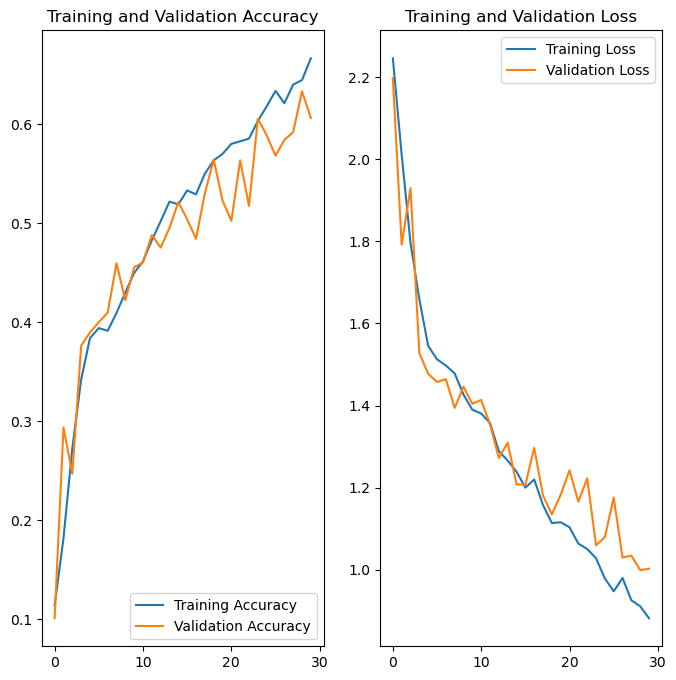

In [165]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



### Model inference:

Upto now we are concentrated on model building and training. Also we have tuned many parameters like augmentation, learning rate number of layers etc. Finally we got a good model which is not overfitting on training data and not underfitting.

Now lets test our model on unseen data to check the performance.

In [166]:
# Dataset for Testing
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    Test_data_path,
    labels='inferred',
    label_mode='int', #'categorical',
    color_mode='rgb',
    batch_size=1,
    image_size=(img_height, img_width),
    interpolation='bilinear',
    data_format= 'channels_last',
    verbose=True
)

Found 118 files belonging to 9 classes.


In [167]:
predictions = []
labels =  []
for x, y in test_ds:
    idx_max = np.argmax(model_v3.predict(x))
    predictions.append(class_names[idx_max])
    labels.append(class_names[y.numpy()[0]])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━

In [168]:
from sklearn import metrics
metrics.confusion_matrix(labels, predictions, labels=class_names)

array([[ 4,  4,  0,  1,  0,  5,  1,  1,  0],
       [ 3,  7,  1,  0,  0,  2,  2,  1,  0],
       [ 0,  4,  7,  1,  1,  0,  2,  1,  0],
       [ 0,  0,  0,  0, 12,  2,  0,  2,  0],
       [ 0,  0,  0,  1, 14,  1,  0,  0,  0],
       [ 0,  3,  1,  1,  0, 11,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  2,  0,  0],
       [ 0,  6,  0,  1,  2,  2,  0,  5,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  2]], dtype=int64)

In [169]:
metrics_cancer = metrics.classification_report(labels, predictions,labels=class_names ,output_dict=True)
metrics_cancer_df = pd.DataFrame(metrics_cancer)
metrics_cancer_df.drop(["macro avg","weighted avg"], axis=1)

,actinic keratosis,basal cell carcinoma,dermatofibroma,melanoma,nevus,pigmented benign keratosis,seborrheic keratosis,squamous cell carcinoma,vascular lesion,accuracy
precision,0.571429,0.291667,0.636364,0.0,0.482759,0.478261,0.285714,0.500000,1.000000,0.440678
recall,0.250000,0.437500,0.437500,0.0,0.875000,0.687500,0.666667,0.312500,0.666667,0.440678
f1-score,0.347826,0.350000,0.518519,0.0,0.622222,0.564103,0.400000,0.384615,0.800000,0.440678
support,16.000000,16.000000,16.000000,16.0,16.000000,16.000000,3.000000,16.000000,3.000000,0.440678
